In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent.


We will evaluate the Mean Absolute Error (MAE) and the Root Mean Square Error (RMSE) of the models. For metrics are better the smaller they are.

> Since our data has multiple features we are going to use multivariate or dependent multi-series forecasting methods

In [ ]:
# clean_METData = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_METData.csv')
data = clean_METData[['date','T2M_RANGE','T2M_MIN','WS10M_MAX','PRECTOTCORR','SPI']]
data.head()

,date,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
0,1991-01-29,-257.431429,14.625429,8.362857,0.530000,0.644588
1,1991-02-05,-257.098571,14.680000,8.398000,0.329714,0.551844
2,1991-02-12,-257.569143,15.220286,8.444000,0.428857,0.554402
3,1991-02-19,-258.402286,16.105714,8.074857,0.562857,0.778456
4,1991-02-26,-257.958571,15.976857,8.043429,0.442571,0.649131


In [ ]:
# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('7D')
data = data.sort_index()
data.head()

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
date,,,,,
1991-01-29,-257.431429,14.625429,8.362857,0.530000,0.644588
1991-02-05,-257.098571,14.680000,8.398000,0.329714,0.551844
1991-02-12,-257.569143,15.220286,8.444000,0.428857,0.554402
1991-02-19,-258.402286,16.105714,8.074857,0.562857,0.778456
1991-02-26,-257.958571,15.976857,8.043429,0.442571,0.649131


In [ ]:
# Split data into train-val-test
# ==============================================================================
end_train = '2020-01-01 '
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 1991-01-29 00:00:00 --- 2019-12-31 00:00:00   (n=1510)
Test dates  : 2020-01-07 00:00:00 --- 2023-03-28 00:00:00   (n=169)


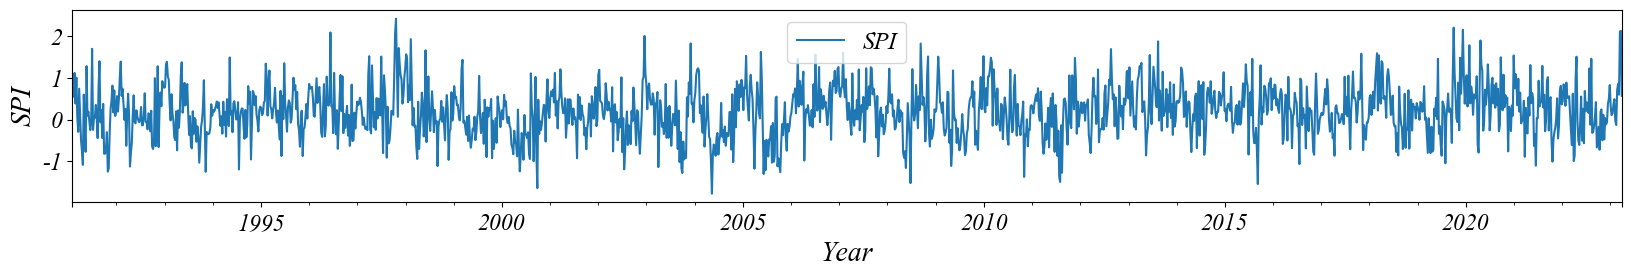

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
rdata['SPI'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2 )
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17)

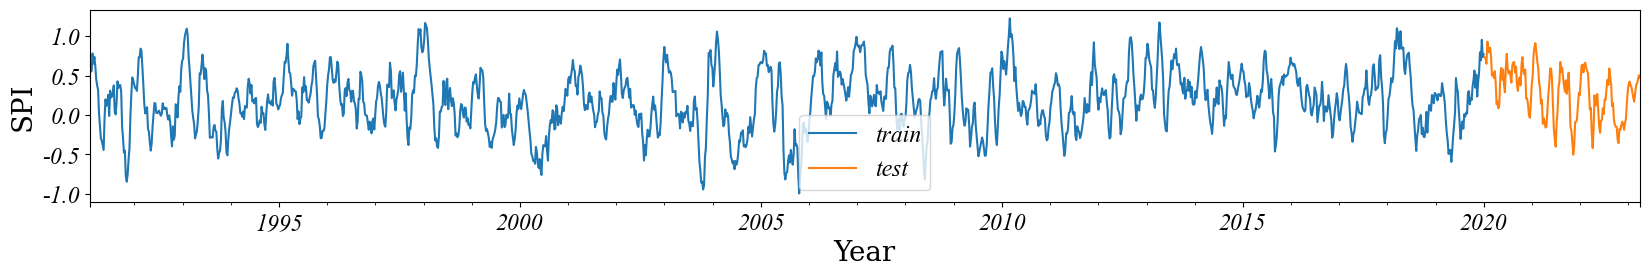

In [ ]:
# Plot
# ==============================================================================
#define font family to use for all text
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['font.family'] = 'Times New Roman'

font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['SPI'].plot(ax=ax, label='train')
data_test['SPI'].plot(ax=ax, label='test')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.rcParams['axes.unicode_minus'] = False
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

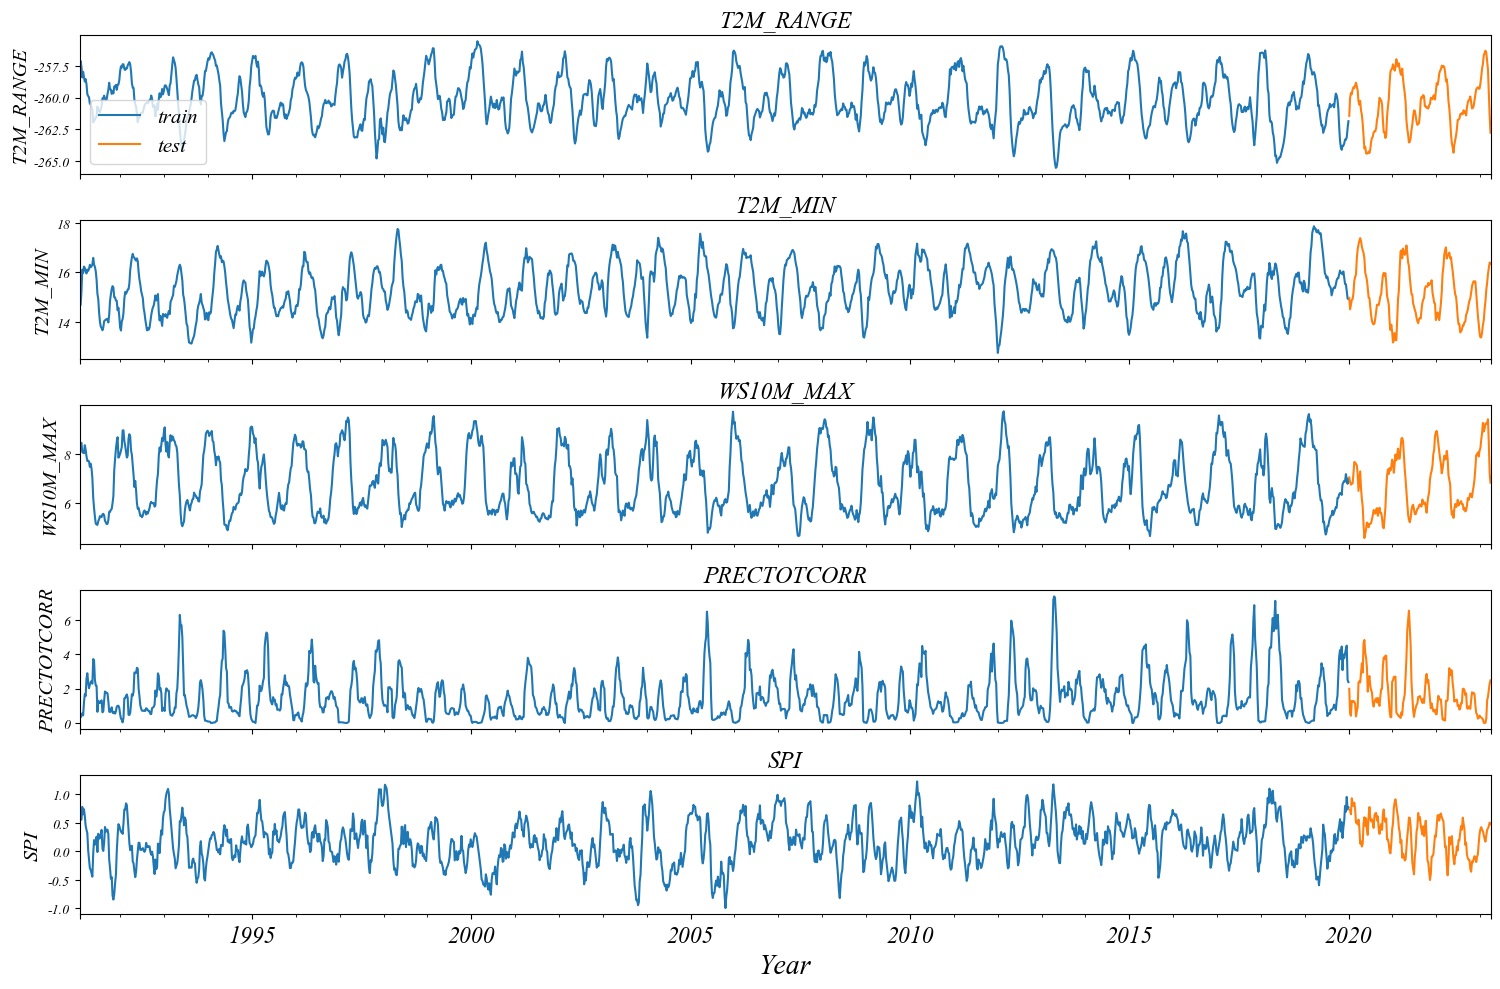

In [ ]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 10), sharex=True)
font2 = {'family':'serif','color':'black','size':20}

data_train['T2M_RANGE'].plot(label='train', ax=axes[0])
data_test['T2M_RANGE'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('Year',fontdict = font2)
axes[0].set_ylabel('T2M_RANGE',fontsize=15)
axes[0].set_title('T2M_RANGE',fontsize=17)
axes[0].legend(fontsize=15)

data_train['T2M_MIN'].plot(label='train', ax=axes[1])
data_test['T2M_MIN'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('Year',fontdict = font2)
axes[1].set_ylabel('T2M_MIN',fontsize=15)
axes[1].set_title('T2M_MIN',fontsize=17)

data_train['WS10M_MAX'].plot(label='train', ax=axes[2])
data_test['WS10M_MAX'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('Year',fontdict = font2)
axes[2].set_ylabel('WS10M_MAX',fontsize=15)
axes[2].set_title('WS10M_MAX',fontsize=17)

data_train['PRECTOTCORR'].plot(label='train', ax=axes[3])
data_test['PRECTOTCORR'].plot(label='test', ax=axes[3])
axes[3].set_xlabel('Year',fontdict = font2)
axes[3].set_ylabel('PRECTOTCORR', fontsize=15)
axes[3].set_title('PRECTOTCORR',fontsize=17)

data_train['SPI'].plot(label='train', ax=axes[4])
data_test['SPI'].plot(label='test', ax=axes[4])
axes[4].set_xlabel('Year',fontdict = font2)
axes[4].set_ylabel('SPI',fontsize=15)
axes[4].set_title('SPI',fontsize=17)
plt.xticks(fontsize=17)
fig.tight_layout()
plt.show();

#### MLP

In [ ]:
# data must be split into input/output samples in order to train a model
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    end_ix = i + n_steps
    if end_ix > len(sequences)-1:
      break
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
#Scaling the dataset
from sklearn.preprocessing import MinMaxScaler
scaler=StandardScaler()
train_data=scaler.fit_transform(np.array(data_train))
test_data=scaler.fit_transform(np.array(data_test))
#print(df_train)

In [ ]:
# multivariate data preparation
from numpy import array
from numpy import hstack

in_seq1 = np.array(train_data[:,0])
in_seq2 = np.array(train_data[:,1])
in_seq3 = np.array(train_data[:,2])
in_seq4 = np.array(train_data[:,3])
out_seq = np.array(train_data[:,4])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
train_dataset = hstack((in_seq1, in_seq2,in_seq3,in_seq4, out_seq))

In [ ]:
in_seq1 = np.array(test_data[:,0])
in_seq2 = np.array(test_data[:,1])
in_seq3 = np.array(test_data[:,2])
in_seq4 = np.array(test_data[:,3])
out_seq = np.array(test_data[:,4])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

test_dataset = hstack((in_seq1, in_seq2,in_seq3,in_seq4, out_seq))

In [ ]:
train_data

array([[ 1.43543796e+00, -7.04438977e-01,  1.28092447e+00,
        -7.30277663e-01,  1.25458242e+00],
       [ 1.61148625e+00, -6.48537373e-01,  1.30950388e+00,
        -8.86148691e-01,  1.00485530e+00],
       [ 1.36260082e+00, -9.50822233e-02,  1.34691271e+00,
        -8.08991420e-01,  1.01174386e+00],
       ...,
       [-1.58125903e+00, -6.63997248e-02,  1.42859793e-01,
         2.36335089e+00,  2.08369890e+00],
       [-1.21027315e+00, -3.85126672e-01, -2.69615338e-04,
         8.09977135e-01,  1.49184292e+00],
       [-9.08044325e-01, -4.03272743e-01,  1.65630381e-01,
         7.10584339e-01,  1.58857073e+00]])

In [ ]:
lags = 25
# convert into input/output
X_train, y_train = split_sequences(train_dataset, lags)
X_test, y_test = split_sequences(test_dataset, lags)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_input))
X_test = X_test.reshape((X_test.shape[0], n_input))

In [ ]:
X_train.shape,y_train.shape

((1505, 25), (1505, 5))

In [ ]:
X_test.shape,y_test.shape

((164, 25), (164, 5))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
# define model
def MLP_model():
  model = Sequential()
  model.add(Dense(100, activation='relu', input_dim=n_input))
  model.add(Dense(5))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
# define the grid search parameters
batchSize = [10,20, 50,100,200]
epochs = [20,50,100]

In [ ]:
# create model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
model = KerasRegressor(build_fn=MLP_model)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
parameter_grid = dict(batch_size=batchSize, epochs=epochs)

In [ ]:
grid = HalvingGridSearchCV(estimator=model, param_grid=parameter_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 0.6493
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 0.2405
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 0.1705
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 0.1397
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 0.1214
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 0.1095
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 0.1004
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0940
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0896
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0859
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0824
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0795
Epoch 13/100
31/31 [=================

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.085270 using {'batch_size': 50, 'epochs': 100}
-0.143378 (0.013918) with: {'batch_size': 10, 'epochs': 20}
-0.131360 (0.023442) with: {'batch_size': 10, 'epochs': 50}
-0.124309 (0.021119) with: {'batch_size': 10, 'epochs': 100}
-0.180896 (0.012543) with: {'batch_size': 20, 'epochs': 20}
-0.140619 (0.016777) with: {'batch_size': 20, 'epochs': 50}
-0.122528 (0.014055) with: {'batch_size': 20, 'epochs': 100}
-0.252757 (0.052914) with: {'batch_size': 50, 'epochs': 20}
-0.177211 (0.032993) with: {'batch_size': 50, 'epochs': 50}
-0.128669 (0.013759) with: {'batch_size': 50, 'epochs': 100}
-0.330319 (0.052753) with: {'batch_size': 100, 'epochs': 20}
-0.186249 (0.029265) with: {'batch_size': 100, 'epochs': 50}
-0.143111 (0.036330) with: {'batch_size': 100, 'epochs': 100}
-0.452724 (0.078681) with: {'batch_size': 200, 'epochs': 20}
-0.222803 (0.031614) with: {'batch_size': 200, 'epochs': 50}
-0.163287 (0.031421) with: {'batch_size': 200, 'epochs': 100}
-0.100737 (0.008912) with: {'batc

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
# define model
def MLP_model(neurons,optimizers):
  model = Sequential()
  model.add(Dense(neurons, activation='relu', input_dim=n_input))
  model.add(Dense(5))
  model.compile(optimizer=optimizers, loss='mse')
  return model

In [ ]:
# create model
model = KerasRegressor(build_fn=MLP_model, epochs=100, batch_size=50)
# define the grid search parameters
neurons = [30, 50, 100,128,150]
optimizer = ['SGD', 'RMSprop', 'Adam']
param_grid = dict(neurons=neurons,optimizers=optimizer)
grid = HalvingGridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 0.7565
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 0.2676
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 0.1816
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 0.1469
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 0.1260
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 0.1130
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 0.1041
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0966
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0920
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0876
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0848
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0823
Epoch 13/100
31/31 [=================

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.081518 using {'neurons': 100, 'optimizers': 'Adam'}
-0.303991 (0.019018) with: {'neurons': 30, 'optimizers': 'SGD'}
-0.183946 (0.042478) with: {'neurons': 30, 'optimizers': 'RMSprop'}
-0.254428 (0.002136) with: {'neurons': 30, 'optimizers': 'Adam'}
-0.268093 (0.044326) with: {'neurons': 50, 'optimizers': 'SGD'}
-0.157606 (0.028035) with: {'neurons': 50, 'optimizers': 'RMSprop'}
-0.182424 (0.010638) with: {'neurons': 50, 'optimizers': 'Adam'}
-0.252700 (0.032152) with: {'neurons': 100, 'optimizers': 'SGD'}
-0.155390 (0.018847) with: {'neurons': 100, 'optimizers': 'RMSprop'}
-0.153027 (0.018703) with: {'neurons': 100, 'optimizers': 'Adam'}
-0.236626 (0.016715) with: {'neurons': 128, 'optimizers': 'SGD'}
-0.139900 (0.017170) with: {'neurons': 128, 'optimizers': 'RMSprop'}
-0.149586 (0.024506) with: {'neurons': 128, 'optimizers': 'Adam'}
-0.212751 (0.014805) with: {'neurons': 150, 'optimizers': 'SGD'}
-0.138813 (0.010729) with: {'neurons': 150, 'optimizers': 'RMSprop'}
-0.140539 (

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(5))
model.compile(optimizer='Adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
history=model.fit(X_train, y_train, batch_size= 50, epochs=100, validation_split=0.2, verbose=1, shuffle=False)

Epoch 1/100
25/25 [==============================] - 7s 19ms/step - loss: 0.8312 - val_loss: 0.4825
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.3302 - val_loss: 0.2993
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.2270 - val_loss: 0.2291
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 0.1782 - val_loss: 0.1925
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 0.1509 - val_loss: 0.1706
Epoch 6/100
25/25 [==============================] - 0s 8ms/step - loss: 0.1334 - val_loss: 0.1563
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.1212 - val_loss: 0.1462
Epoch 8/100
25/25 [==============================] - 0s 7ms/step - loss: 0.1121 - val_loss: 0.1389
Epoch 9/100
25/25 [==============================] - 0s 6ms/step - loss: 0.1052 - val_loss: 0.1331
Epoch 10/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0997 - val_loss: 0.1284
Epoch 11

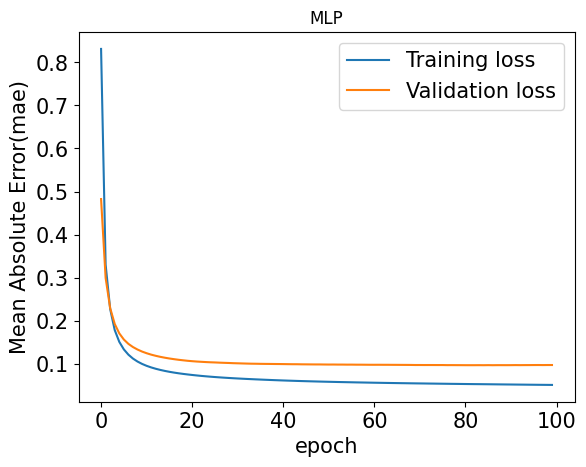

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('MLP')
plt.xlabel('epoch', fontsize=15)
plt.ylabel('Mean Absolute Error(mae)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

In [ ]:
#train_predict=model.predict(X_train)
test_predict=grid_result.predict(X_test)

6/6 [==============================] - 0s 5ms/step


In [ ]:
X_test

array([[-4.86189218e-01, -1.68727604e-01,  2.57427331e-01, ...,
         4.49606651e-02, -3.40963251e-01,  1.74251620e+00],
       [ 2.28756134e-01, -6.04567032e-01,  8.92143665e-02, ...,
         3.92144400e-01, -3.08522310e-01,  1.57541726e+00],
       [ 4.13907557e-01, -4.38136059e-01,  1.92944152e-03, ...,
         7.86515784e-01, -3.36026586e-01,  1.76241788e+00],
       ...,
       [ 1.97252528e+00, -5.93274462e-01,  1.94738084e+00, ...,
         2.26938153e+00, -9.69509522e-02,  3.55642359e-01],
       [ 2.07020471e+00, -3.08002634e-01,  2.12121720e+00, ...,
         1.43125065e+00,  2.19130472e-01,  4.84396852e-01],
       [ 1.99350722e+00,  1.35634045e-01,  2.10997040e+00, ...,
         3.86032011e-01,  5.35211897e-01,  6.77276361e-01]])

In [ ]:
test_predict

array([[ 6.91361547e-01, -1.05801225e-01,  1.52761847e-01,
        -2.04475939e-01,  2.01242161e+00],
       [ 6.50038302e-01,  3.11370865e-02,  4.81732547e-01,
        -1.83955848e-01,  1.51186264e+00],
       [ 5.71834087e-01,  6.10372782e-01,  8.05527389e-01,
        -1.98038340e-01,  1.54878736e+00],
       [ 6.66057229e-01,  9.26195562e-01,  8.52576256e-01,
        -3.63997936e-01,  1.18580019e+00],
       [ 9.63908374e-01,  1.05637670e+00,  8.88256133e-01,
        -1.08013177e+00,  2.29100823e-01],
       [ 6.52943790e-01,  1.40459371e+00,  7.72190630e-01,
        -7.40159094e-01,  5.54726422e-01],
       [ 4.97035295e-01,  1.69879639e+00,  4.72116321e-01,
        -4.39454108e-01,  5.11450589e-01],
       [-1.33930713e-01,  1.61766183e+00, -2.54964292e-01,
         9.89176333e-01,  8.15878034e-01],
       [-3.13966781e-01,  1.97466373e+00,  1.40529260e-01,
         1.14249933e+00,  9.99180153e-02],
       [-1.73025876e-01,  2.05257654e+00,  3.06522489e-01,
         1.43545246e+00

In [ ]:
#train_predict=scaler.inverse_transform(train_predict)
y_pred_future=scaler.inverse_transform(test_predict)

In [ ]:
y_pred_future=pd.DataFrame(y_pred_future)
y_pred_future

,0,1,2,3,4
0,-259.467743,14.979367,6.839261,1.230278,0.932882
1,-259.087372,15.197159,7.383330,1.371534,0.828072
2,-259.562775,15.854999,7.987542,1.387970,0.844056
3,-259.025238,16.096125,7.914657,1.175347,0.639344
4,-258.605865,16.175272,7.965915,0.454847,0.373646
...,...,...,...,...,...
159,-257.075500,15.706132,8.922197,0.481520,0.291649
160,-258.082611,15.977279,8.780983,1.721087,0.421429
161,-258.909546,16.250099,8.966655,2.021064,0.435089
162,-260.632629,16.325447,7.980177,2.648052,0.467443


In [ ]:
y_pred_future.shape

(164, 5)

In [ ]:
datap = data_test[-(y_pred_future.shape[0]):]
datap

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
date,,,,,
2020-02-11,-259.179429,15.156000,7.207143,1.277429,0.792103
2020-02-18,-259.250000,15.660571,7.668000,1.244000,0.852226
2020-02-25,-259.036286,15.810569,7.654571,1.112857,0.735921
2020-03-03,-258.810857,15.909237,7.585143,0.387143,0.500894
2020-03-10,-259.123143,16.563809,7.538857,0.690286,0.524803
...,...,...,...,...,...
2023-02-28,-257.115143,15.579143,9.258000,1.323714,0.378414
2023-03-07,-257.793143,15.934857,9.400857,1.534571,0.399931
2023-03-14,-259.648571,16.177143,8.421429,1.918735,0.441327


In [ ]:
y_pred_future['date']=datap.index
y_pred_future=y_pred_future.set_index('date')

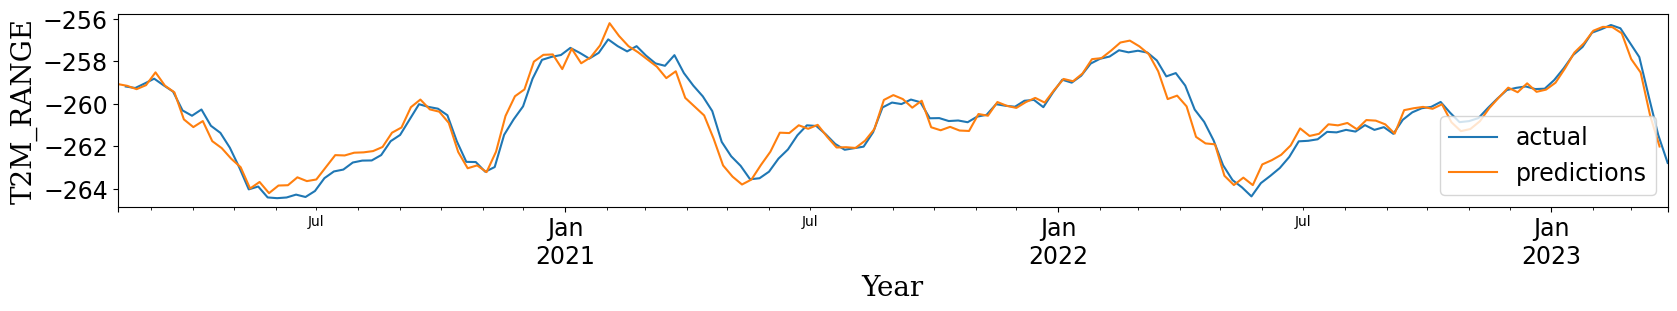

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
datap.T2M_RANGE.plot(ax=ax, label='actual')
y_pred_future[0].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("T2M_RANGE",fontdict = font2)
ax.legend(fontsize=17);

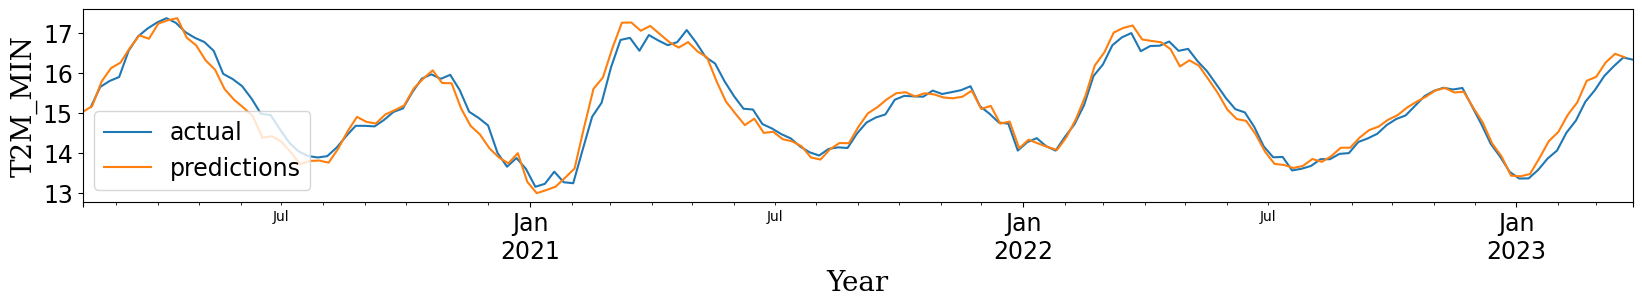

In [ ]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
datap.T2M_MIN.plot(ax=ax, label='actual')
y_pred_future[1].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("T2M_MIN",fontdict = font2)
ax.legend(fontsize=17);

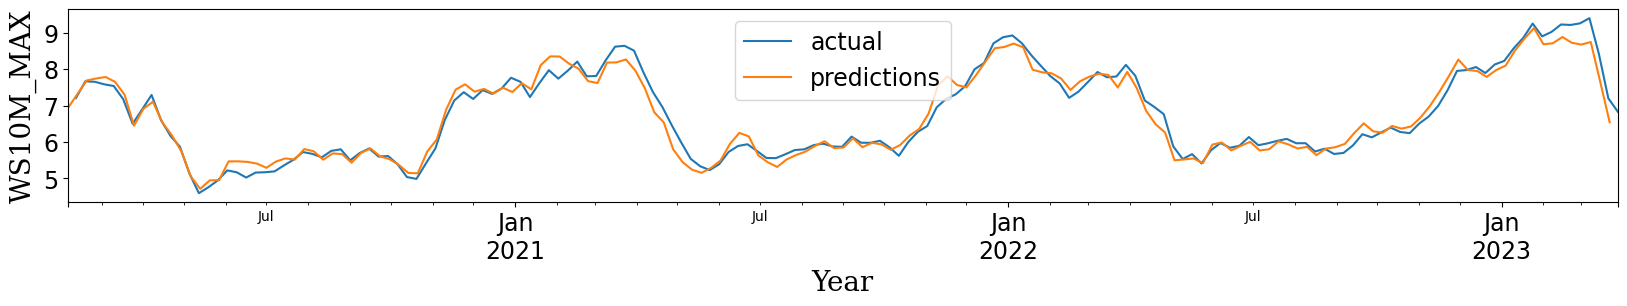

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
datap.WS10M_MAX.plot(ax=ax, label='actual')
y_pred_future[2].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("WS10M_MAX",fontdict = font2)
ax.legend(fontsize=17);

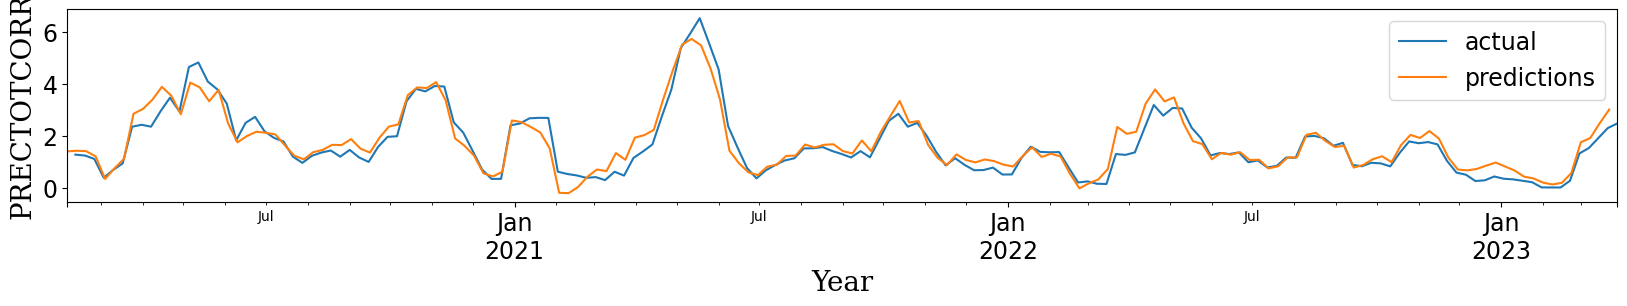

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
datap.PRECTOTCORR.plot(ax=ax, label='actual')
y_pred_future[3].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("PRECTOTCORR",fontdict = font2)
ax.legend(fontsize=17);

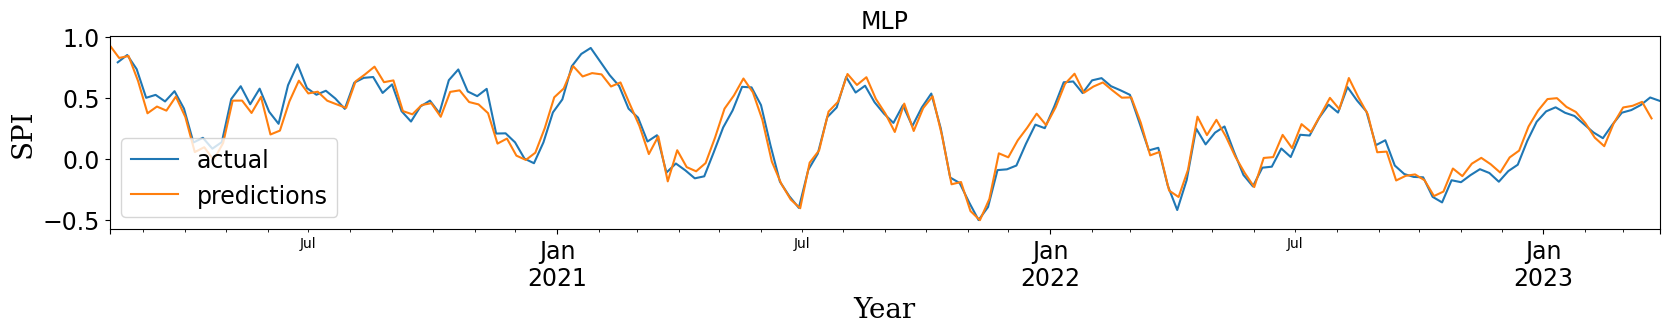

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
datap.SPI.plot(ax=ax, label='actual')
y_pred_future[4].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='MLP')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(datap.SPI,y_pred_future[4])
mse = mean_squared_error(datap.SPI,y_pred_future[4])
r2 = r2_score(datap.SPI,y_pred_future[4])
rmse = math.sqrt(mean_squared_error(datap.SPI,y_pred_future[4]))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('RMSE is {}'.format(rmse))

The model performance for testing set:
--------------------------------------

MAE is 0.11434741867622096
MSE is 0.020073156972218426
R2 is 0.7966370959426194
RMSE is 0.14167976909996158


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(y_test,test_predict)
mse = mean_squared_error(y_test,test_predict)
r2 = r2_score(y_test,test_predict)
rmse = math.sqrt(mean_squared_error(y_test,test_predict))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('RMSE is {}'.format(rmse))

The model performance for testing set:
--------------------------------------

MAE is 0.22715127600129006
MSE is 0.09476258048349431
R2 is 0.9046404182370364
RMSE is 0.30783531389932234


In [ ]:
X_test.shape

(164, 25)

In [ ]:
#Taking the last 500 values as input to predic future values
x_input=X_test[-1:]
x_input.shape

(1, 25)

In [ ]:
x_tempinput=x_input

In [ ]:
# demonstrate prediction for next 5 year
from numpy import array
from numpy import zeros, newaxis

lst_output=[]

for i in range(0,300):
        #print(temp_input)
        x_input=x_tempinput
        print("{} input: \n\n{}".format(i,x_input))
        yhat = grid_result.predict(x_input)
        print("\n{} th output: {}\n\n\n".format(i,yhat))

        x_tempinput=np.append(x_tempinput,yhat)
        x_tempinput=x_tempinput[5:]
        x_tempinput = x_tempinput[newaxis,:]
        lst_output.extend(yhat.tolist())

Streaming output truncated to the last 5000 lines.


10 input: 

[[-0.69197124  1.3648169   0.02272452  0.95977789  0.2175108  -0.7399087
   1.36520588 -0.2733916   0.7670204  -0.28799242 -0.921624    1.30214679
  -0.75712228  1.14703274 -0.43141156 -0.84047514  1.09151065 -0.68488145
   1.24553752 -0.6791324  -0.78241533  0.80817688 -0.4495542   1.40351772
  -0.69808841 -0.80820733  0.60979509 -0.6662969   1.23178267 -0.33551455
  -0.86979854  0.35376561 -0.89048636  0.9876892  -0.10956044 -1.00801134
   0.06457882 -0.77313131  0.53620625  0.11760284 -1.22333789 -0.11062841
  -0.73745906  0.46379662  0.55270618 -1.21941495 -0.29795945 -0.83545154
   0.28563082  0.83671206]]
1/1 [==============================] - 0s 27ms/step

10 th output: [-1.1943198  -0.46040893 -0.7436954  -0.01176294  0.86322165]



11 input: 

[[-0.7399087   1.36520588 -0.2733916   0.7670204  -0.28799242 -0.921624
   1.30214679 -0.75712228  1.14703274 -0.43141156 -0.84047514  1.09151065
  -0.68488145  1.24553752 

In [ ]:
print(lst_output)

[-0.698051929473877, 1.2424616813659668, 0.166691392660141, 1.2170894145965576, 0.4921804964542389, -1.0392835140228271, 1.162322759628296, -0.053378861397504807, 1.5500738620758057, 0.3683515787124634, -1.4716780185699463, 1.091413140296936, -0.4492141604423523, 2.2866897583007812, 0.4674060642719269, -1.618222951889038, 0.9584641456604004, -0.38180312514305115, 2.755763292312622, 0.329196035861969, -1.869522213935852, 0.8868602514266968, -0.29023271799087524, 3.24719500541687, 0.6729876399040222, -2.1687934398651123, 0.8703030347824097, -0.4651440382003784, 2.97019362449646, 0.9620383381843567, -2.294379472732544, 0.7374025583267212, -0.5939604043960571, 1.9417431354522705, 0.930236279964447, -2.2003819942474365, 0.4315597414970398, -0.458976149559021, 1.1681818962097168, 1.1462392807006836, -2.0197227001190186, -0.04686441645026207, -0.20249870419502258, 0.8791711926460266, 1.667869210243225, -1.7700995206832886, -0.5220842361450195, 0.04098730906844139, 0.24256783723831177, 1.75100

In [ ]:
len(lst_output)

1500

In [ ]:
prediction=np.array(lst_output)

In [ ]:
train_date=pd.to_datetime(data.index)
train_date

DatetimeIndex(['1991-01-29', '1991-02-05', '1991-02-12', '1991-02-19',
               '1991-02-26', '1991-03-05', '1991-03-12', '1991-03-19',
               '1991-03-26', '1991-04-02',
               ...
               '2023-01-24', '2023-01-31', '2023-02-07', '2023-02-14',
               '2023-02-21', '2023-02-28', '2023-03-07', '2023-03-14',
               '2023-03-21', '2023-03-28'],
              dtype='datetime64[ns]', name='date', length=1679, freq='7D')

In [ ]:
n_week_for_prediction=300  #let us predict 1 year

predict_period_dates = pd.date_range(list(train_date)[-1], periods=n_week_for_prediction, freq='7D').tolist()
print(predict_period_dates)


[Timestamp('2023-03-28 00:00:00', freq='7D'), Timestamp('2023-04-04 00:00:00', freq='7D'), Timestamp('2023-04-11 00:00:00', freq='7D'), Timestamp('2023-04-18 00:00:00', freq='7D'), Timestamp('2023-04-25 00:00:00', freq='7D'), Timestamp('2023-05-02 00:00:00', freq='7D'), Timestamp('2023-05-09 00:00:00', freq='7D'), Timestamp('2023-05-16 00:00:00', freq='7D'), Timestamp('2023-05-23 00:00:00', freq='7D'), Timestamp('2023-05-30 00:00:00', freq='7D'), Timestamp('2023-06-06 00:00:00', freq='7D'), Timestamp('2023-06-13 00:00:00', freq='7D'), Timestamp('2023-06-20 00:00:00', freq='7D'), Timestamp('2023-06-27 00:00:00', freq='7D'), Timestamp('2023-07-04 00:00:00', freq='7D'), Timestamp('2023-07-11 00:00:00', freq='7D'), Timestamp('2023-07-18 00:00:00', freq='7D'), Timestamp('2023-07-25 00:00:00', freq='7D'), Timestamp('2023-08-01 00:00:00', freq='7D'), Timestamp('2023-08-08 00:00:00', freq='7D'), Timestamp('2023-08-15 00:00:00', freq='7D'), Timestamp('2023-08-22 00:00:00', freq='7D'), Timestamp

In [ ]:
predict_period_dates = pd.to_datetime(predict_period_dates)

In [ ]:
predict_period_dates

DatetimeIndex(['2023-03-28', '2023-04-04', '2023-04-11', '2023-04-18',
               '2023-04-25', '2023-05-02', '2023-05-09', '2023-05-16',
               '2023-05-23', '2023-05-30',
               ...
               '2028-10-17', '2028-10-24', '2028-10-31', '2028-11-07',
               '2028-11-14', '2028-11-21', '2028-11-28', '2028-12-05',
               '2028-12-12', '2028-12-19'],
              dtype='datetime64[ns]', length=300, freq=None)

In [ ]:
y_pred_future=prediction

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [ ]:
y_pred_future

array([-0.69805193,  1.24246168,  0.16669139, ...,  2.26799488,
        2.29746461,  6.90027142])

In [ ]:
#y_pred_future=np.array(y_pred_future)
y_pred_future = y_pred_future.reshape(300,5)

In [ ]:
y_pred_future

array([[ -0.69805193,   1.24246168,   0.16669139,   1.21708941,
          0.4921805 ],
       [ -1.03928351,   1.16232276,  -0.05337886,   1.55007386,
          0.36835158],
       [ -1.47167802,   1.09141314,  -0.44921416,   2.28668976,
          0.46740606],
       ...,
       [-18.48679352,  11.2611618 ,  -3.3842926 ,  21.23102188,
          9.48072815],
       [-15.81140232,   4.98800659,  -0.94417059,  11.58469677,
          8.8974638 ],
       [-11.70991802,  -1.613814  ,   2.26799488,   2.29746461,
          6.90027142]])

In [ ]:
y_pred_future = scaler.inverse_transform(y_pred_future)

In [ ]:
df_forecast = pd.DataFrame(y_pred_future, columns = ['trange_pred','tmin_pred','wmax_pred','P_pred','SPI_pred'])
df_forecast

,trange_pred,tmin_pred,wmax_pred,P_pred,SPI_pred
0,-261.863832,16.467023,6.943681,3.131650,0.443829
1,-262.551530,16.381863,6.686510,3.536358,0.404017
2,-263.422951,16.306512,6.223942,4.431637,0.435864
3,-263.718289,16.165234,6.302718,5.001747,0.391428
4,-264.224742,16.089144,6.409726,5.599031,0.501961
...,...,...,...,...,...
295,-294.916076,35.223105,0.484538,38.208142,0.894518
296,-298.077105,31.582484,0.219378,35.384832,2.545280
297,-297.714174,27.113350,2.794049,27.456492,3.333754
298,-292.322354,20.447210,5.645543,15.732392,3.146228


In [ ]:
df_forcdate = pd.DataFrame({'Date':np.array(forecast_dates).flatten()})
df_forcdate

,Date
0,2023-03-28
1,2023-04-04
2,2023-04-11
3,2023-04-18
4,2023-04-25
...,...
295,2028-11-21
296,2028-11-28
297,2028-12-05
298,2028-12-12


In [ ]:
df_forecast['Date'] = df_forcdate['Date']
df_forecast=df_forecast.set_index('Date')
df_forecast.head()

,trange_pred,tmin_pred,wmax_pred,P_pred,SPI_pred
Date,,,,,
2023-03-28,-261.863832,16.467023,6.943681,3.131650,0.443829
2023-04-04,-262.551530,16.381863,6.686510,3.536358,0.404017
2023-04-11,-263.422951,16.306512,6.223942,4.431637,0.435864
2023-04-18,-263.718289,16.165234,6.302718,5.001747,0.391428
2023-04-25,-264.224742,16.089144,6.409726,5.599031,0.501961


Text(0, 0.5, 'SPI')

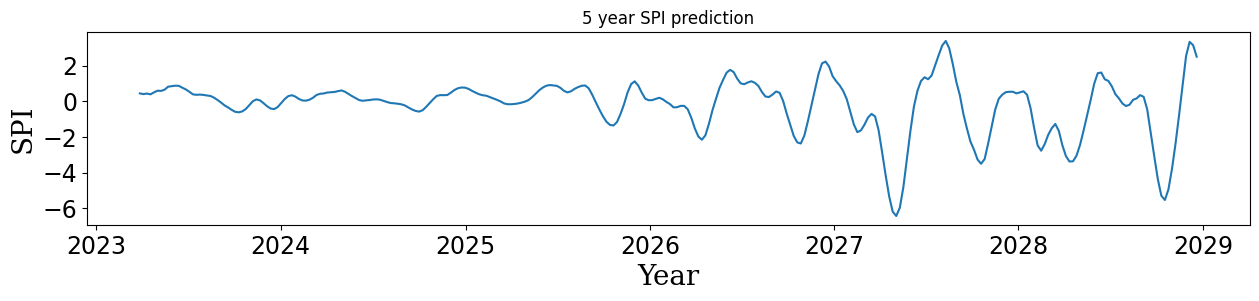

In [ ]:
#df_forecast['SPI_pred'].plot(figsize=(10, 2))

# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(15, 2.5))
df_forecast['SPI_pred'].plot(ax=ax, title='5 year SPI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
#ax.legend();

Text(0, 0.5, 'SPI')

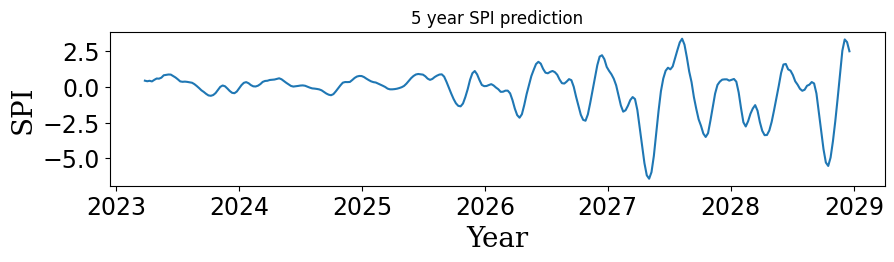

In [ ]:
#df_forecast['SPI_pred'].plot(figsize=(10, 2))

# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
df_forecast['SPI_pred'].plot(ax=ax, title='5 year SPI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)

Text(0, 0.5, 'precip')

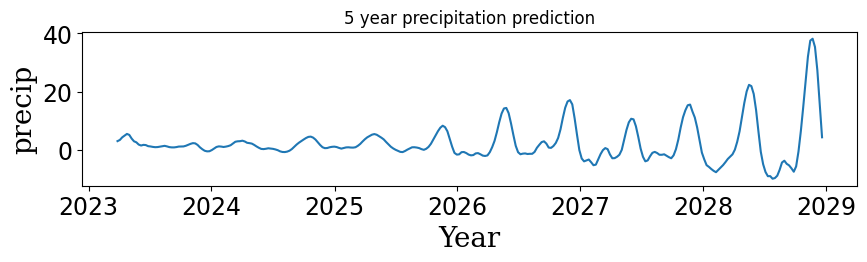

In [ ]:

# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
df_forecast['P_pred'].plot(ax=ax, title='5 year precipitation prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("precip",fontdict = font2)

Text(0, 0.5, 'trange_pred')

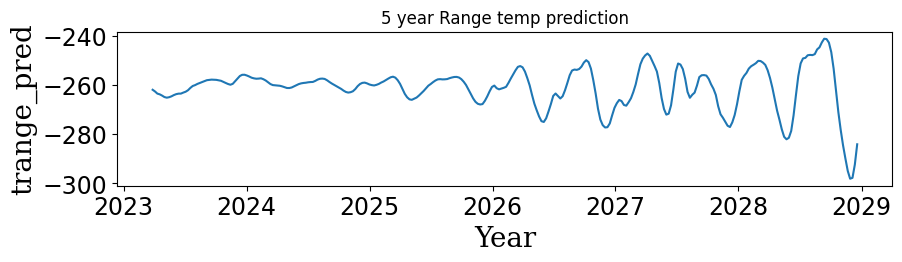

In [ ]:

# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
df_forecast['trange_pred'].plot(ax=ax, title='5 year Range temp prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("trange_pred",fontdict = font2)

Text(0, 0.5, 'tmin_pred')

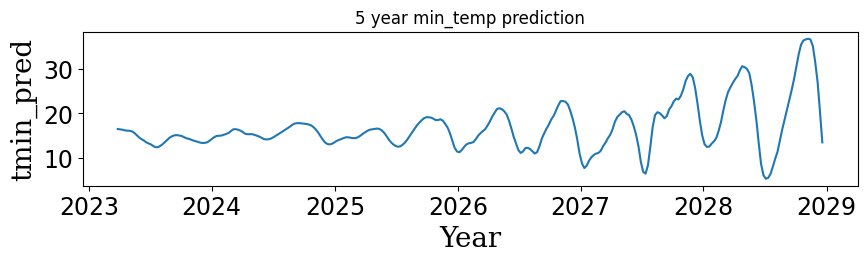

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
df_forecast['tmin_pred'].plot(ax=ax, title='5 year min_temp prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("tmin_pred",fontdict = font2)

Text(0, 0.5, 'wmax_pred')

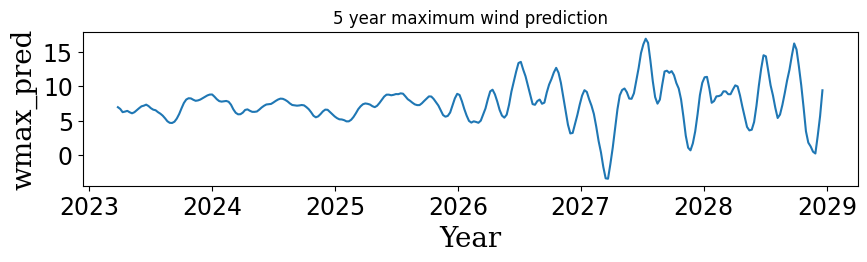

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
df_forecast['wmax_pred'].plot(ax=ax, title='5 year maximum wind prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("wmax_pred",fontdict = font2)